# Hi!

If you're here, you're probably interested on how to segment a song in the NTD paradigm. You should read [1] for details on NTD, [2] for NTD with the different $\beta$-divergences, or [3] for more details on NTD and music segmentation in general.

This notebook can work as a tutorial on how to use the NTD code for music segmentation on your own. Of course, it's related to a version of the code (0.1.6), and should be regularly updated (but this is my job, not yours). Make sure nonetheless that the version you need is also the one of the current version of the notebook.

# Imports
Let's start with external librairies (which are installed automatically if you used `pip install`, otherwise you should install them manually).

In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for loading signals
import librosa

# Module handling annotations for MIR datasets (including RWC Pop)
import mirdata

# Module to manipulate tensors, used here to unfold/fold tensors.
import tensorly as tl

And now, let's import the `BarMusComp` (BarwiseMusicCompression) and `as_seg` (Autosimilarity Segmentation) code:

In [2]:
# Module encapsulating the computation of features from the signal
import barmuscomp.model.signal_to_spectrogram as signal_to_spectrogram

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import as_seg.data_manipulation as dm

# Module to process the input in barwise features
import as_seg.barwise_input as bi

# Module encapsulating the NTD computation 
import barmuscomp.lra as lra # The entire NTD code can be obtained in nn_fac.ntd, see this file for more details.

# Module containing our algorithm used for computing the autosimilarity
import as_seg.autosimilarity_computation as as_comp

# Module containing our algorithm used for segmenting the autosimilarity
import as_seg.CBM_algorithm as CBM

# Plotting module
from barmuscomp.model.common_plot import *

# Import default paths
import barmuscomp.scripts.default_path as paths

# Loading the song, and its annotations
As an example, we will load the song "POP-01" of RWC Pop. You need to possess the song in wav format on your own, as we don't share it.

For this code to work automaticaly, you should modify the paths variables in the file `default_path.py` in 'musicntd/scripts', with you own path to the wav files.

You can also change the song_path with any of your own song (as a wav), but it could come without annotations.

In [3]:
# Song
path_to_beatles_dataset = '/home/a23marmo/datasets/beatles'
beatles = mirdata.initialize('beatles', path_to_beatles_dataset)
beatles.download()

# NB: you have to place the file "01_-_Come_Together.wav" manually in the folder "audio/11_-_Abbey_Road/"
come_together = beatles.track('1101')

references_segments = beatles.load_sections(come_together.sections_path).intervals

song_path = come_together.audio_path

the_signal, sampling_rate = librosa.load(song_path, sr = None)

# Estimates the downbeats, with madmom
bars = dm.get_bars_from_audio(song_path)

INFO: Downloading ['annotations'] to /home/a23marmo/datasets/beatles
INFO: [annotations] downloading The Beatles Annotations.tar.gz
INFO: /home/a23marmo/datasets/beatles/annotations/The Beatles Annotations.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: 
    Unfortunately the audio files of the Beatles dataset are not available
    for download. If you have the Beatles dataset, place the contents into
    a folder called Beatles with the following structure:
        > Beatles/
            > annotations/
            > audio/
    and copy the Beatles folder to /home/a23marmo/datasets/beatles

/tmp/ipykernel_39159/3154688867.py:9: DeprecationWarning: Call to deprecated method load_sections. (Use mirdata.datasets.beatles.load_sections) -- Deprecated since version 0.3.4.
  references_segments = beatles.load_sections(come_together.sections_path).intervals
/home/a23marmo/environnements_venv/msa/lib/python3.10/

# Spectrogram
Let's compute the spectrogram of the song. We work with the Mel Spectrorgram in this code, but you can chose any other feature (either on the file `signal_to_spectrogram.py` from `base_audio`, or by looking at the list on the `librosa` package, which you will have to code).

In [4]:
# Variables for the tensor-spectrogram.
hop_length = 32 # Oversampling the spectrogram, to select frames which will be equally-spaced barwise.
subdivision_bars = 96 # Number of frame per bar in the tensor-spectrogram

feature_object = signal_to_spectrogram.FeatureObject(sr=sampling_rate, feature="mel", hop_length=hop_length) # Mel Spectrogram
spectrogram = feature_object.get_spectrogram(the_signal)

We can compute the tensor-spectrogram (*i.e.* barwise reordering of this spectrogram):

In [5]:
tensor_spectrogram = bi.tensorize_barwise_FTB(spectrogram, bars, hop_length / sampling_rate, subdivision_bars)

Let's plot the raw barwise cosine autosimilarity of this feature:

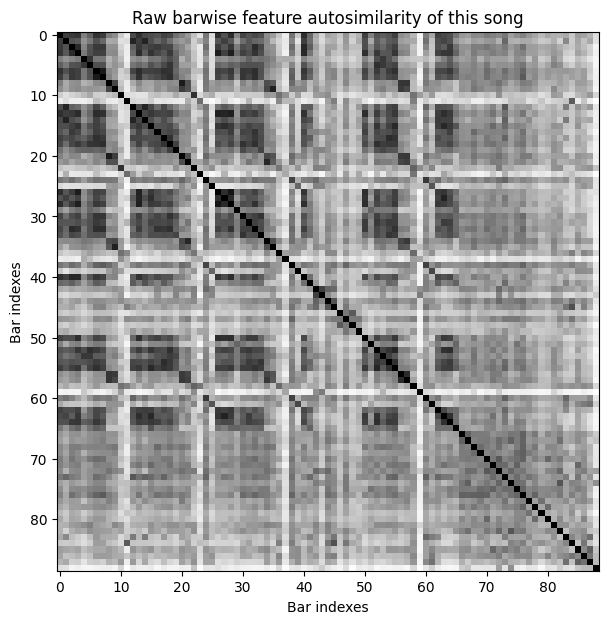

In [6]:
autosimilarity_feature = as_comp.get_cosine_autosimilarity(tl.unfold(tensor_spectrogram, 2))
plot_me_this_spectrogram(autosimilarity_feature, title = "Raw barwise feature autosimilarity of this song", x_axis = "Bar indexes", y_axis = "Bar indexes")

You can segment this autosimilarity if you want to:

In [7]:
segments_feature = CBM.compute_cbm(autosimilarity_feature, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_feature_in_time = dm.segments_from_bar_to_time(segments_feature, bars)

prec_05, rap_05, f_mes_05 = dm.compute_score_of_segmentation(references_segments, segments_feature_in_time, window_length = 0.5)
ipd.display(ipd.Markdown("0.5 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_05,4),round(rap_05,4),round(f_mes_05,4) )))

prec_3, rap_3, f_mes_3 = dm.compute_score_of_segmentation(references_segments, segments_feature_in_time, window_length = 3)
ipd.display(ipd.Markdown("3 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_3,4),round(rap_3,4),round(f_mes_3,4) )))

0.5 seconds tolerance: Precision: **0.3846**, Recall: **0.5**, F measure: **0.4348**

3 seconds tolerance: Precision: **0.3846**, Recall: **0.5**, F measure: **0.4348**

# NTD: Nonnegative Tucker Decomposition
Let's compute the Nonnegative Tucker Decomposition of this tensor-spectrogram.

First, we need to set the dimensions of the decomposition, which correspond to the dimensions of the core. They are set empirically here.

In [8]:
core_dimensions = [24,24,24] # Dimensions of the decomposition

## Euclidean norm: $\beta$ = 2
Below is presetned the decomposition obtained with the HALS algorithm, optimizing the euclidean norm ($\beta$-divergence with $\beta = 2$) between the original and the reconstructed tensor [1].

We plot the matrix $Q^T$, corresponding to the barwise representation of the song in terms of patterns. The patterns are defined by the other factors of the decomposition, $W$, $H$ and slices of $G$.

/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/numpy/lib/function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


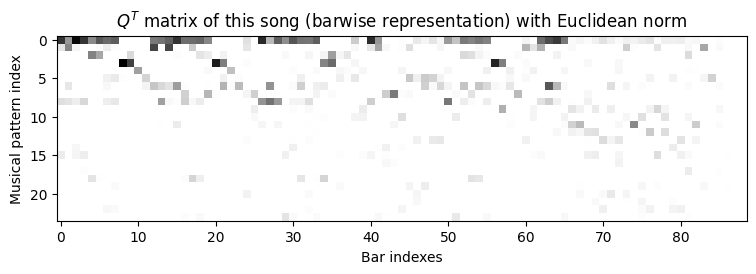

In [9]:
euc_ntd_projection = lra.get_ntd_projection(spectrogram, core_dimensions, bars, beta = 2, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

# The plotting function below is defined in current_plot.py
plot_permuted_factor(euc_ntd_projection, title = "$Q^T$ matrix of this song (barwise representation) with Euclidean norm", x_axis = "Bar indexes", y_axis = "Musical pattern index")

The segmentation is obtained via the autosimilarity matrix of this $Q$ factor, which we plot below:

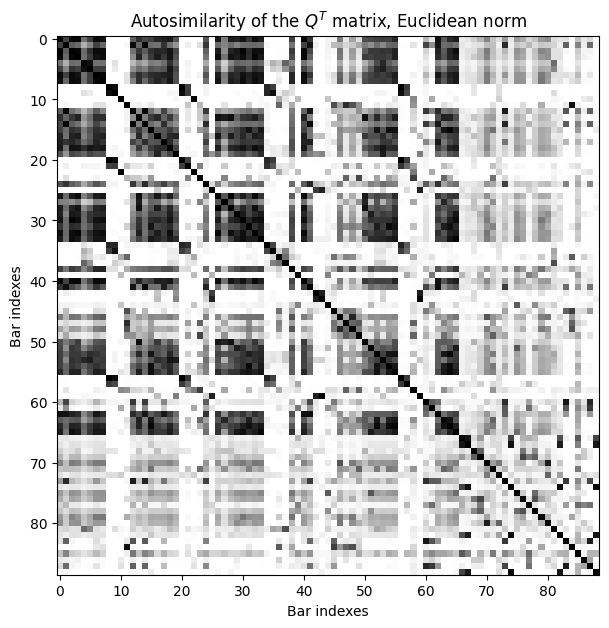

In [10]:
autosimilarity_q_beta2 = as_comp.get_cosine_autosimilarity(euc_ntd_projection)
plot_me_this_spectrogram(autosimilarity_q_beta2, title = "Autosimilarity of the $Q^T$ matrix, Euclidean norm", x_axis = "Bar indexes", y_axis = "Bar indexes")

# Segmenting this autosimilarity
segments_beta2 = CBM.compute_cbm(autosimilarity_q_beta2, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_beta2_in_time = dm.segments_from_bar_to_time(segments_beta2, bars)

Finally, let's compute the segmentation scores:

In [11]:
prec_05, rap_05, f_mes_05 = dm.compute_score_of_segmentation(references_segments, segments_beta2_in_time, window_length = 0.5)
ipd.display(ipd.Markdown("0.5 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_05,4),round(rap_05,4),round(f_mes_05,4) )))

prec_3, rap_3, f_mes_3 = dm.compute_score_of_segmentation(references_segments, segments_beta2_in_time, window_length = 3)
ipd.display(ipd.Markdown("3 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_3,4),round(rap_3,4),round(f_mes_3,4) )))

0.5 seconds tolerance: Precision: **0.4211**, Recall: **0.8**, F measure: **0.5517**

3 seconds tolerance: Precision: **0.4211**, Recall: **0.8**, F measure: **0.5517**

## $\beta$ = 1
Let's redo this processus with the MU algorithm optimizing the Kullback-Leibler divergence ($\beta$-divergence with $\beta = 1$) [2]:

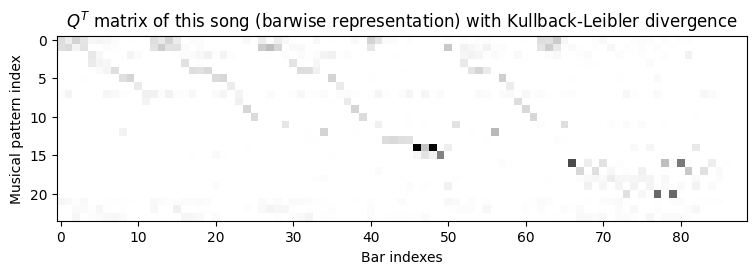

In [12]:
kl_ntd_projection = lra.get_ntd_projection(spectrogram, core_dimensions, bars, beta = 1, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

# The plotting function below is defined in current_plot.py
plot_permuted_factor(kl_ntd_projection, title = "$Q^T$ matrix of this song (barwise representation) with Kullback-Leibler divergence", x_axis = "Bar indexes", y_axis = "Musical pattern index")

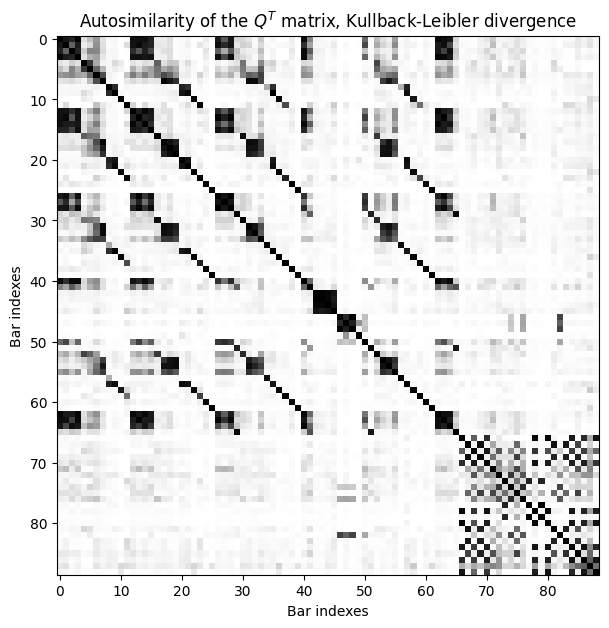

In [13]:
autosimilarity_q_beta1 = as_comp.get_cosine_autosimilarity(kl_ntd_projection)
plot_me_this_spectrogram(autosimilarity_q_beta1, title = "Autosimilarity of the $Q^T$ matrix, Kullback-Leibler divergence", x_axis = "Bar indexes", y_axis = "Bar indexes")

segments_beta1 = CBM.compute_cbm(autosimilarity_q_beta1, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_beta1_in_time = dm.segments_from_bar_to_time(segments_beta1, bars)

In [14]:
prec_05, rap_05, f_mes_05 = dm.compute_score_of_segmentation(references_segments, segments_beta1_in_time, window_length = 0.5)
ipd.display(ipd.Markdown("0.5 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_05,4),round(rap_05,4),round(f_mes_05,4) )))

prec_3, rap_3, f_mes_3 = dm.compute_score_of_segmentation(references_segments, segments_beta1_in_time, window_length = 3)
ipd.display(ipd.Markdown("3 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_3,4),round(rap_3,4),round(f_mes_3,4) )))

0.5 seconds tolerance: Precision: **0.3333**, Recall: **0.7**, F measure: **0.4516**

3 seconds tolerance: Precision: **0.3333**, Recall: **0.7**, F measure: **0.4516**

## $\beta = 0$
Let's redo this processus with the MU algorithm optimizing the Itakura-Saito divergence ($\beta$-divergence with $\beta = 0$) [2]:

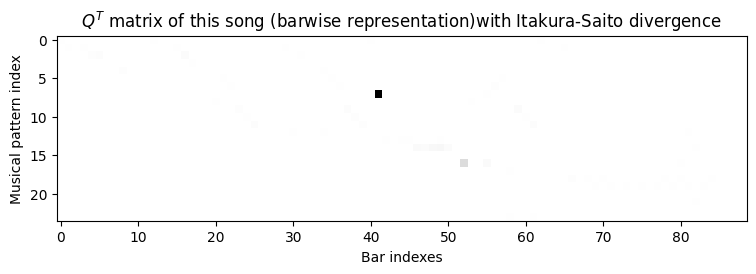

In [15]:
is_ntd_projection = lra.get_ntd_projection(spectrogram, core_dimensions, bars, beta = 0, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

# The plotting function below is defined in current_plot.py
plot_permuted_factor(is_ntd_projection, title = "$Q^T$ matrix of this song (barwise representation)with Itakura-Saito divergence", x_axis = "Bar indexes", y_axis = "Musical pattern index")

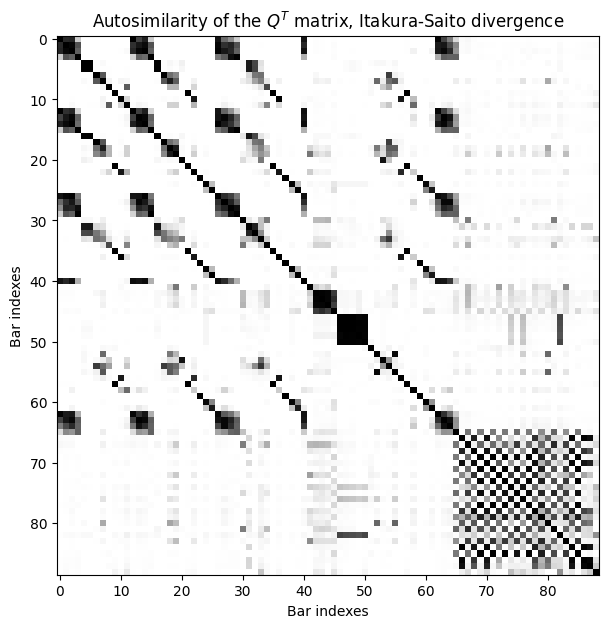

In [16]:
autosimilarity_q_beta0 = as_comp.get_cosine_autosimilarity(is_ntd_projection)
plot_me_this_spectrogram(autosimilarity_q_beta0, title = "Autosimilarity of the $Q^T$ matrix, Itakura-Saito divergence", x_axis = "Bar indexes", y_axis = "Bar indexes")

segments_beta0 = CBM.compute_cbm(autosimilarity_q_beta0, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_beta0_in_time = dm.segments_from_bar_to_time(segments_beta0, bars)

In [17]:
prec_05, rap_05, f_mes_05 = dm.compute_score_of_segmentation(references_segments, segments_beta0_in_time, window_length = 0.5)
ipd.display(ipd.Markdown("0.5 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_05,4),round(rap_05,4),round(f_mes_05,4) )))

prec_3, rap_3, f_mes_3 = dm.compute_score_of_segmentation(references_segments, segments_beta0_in_time, window_length = 3)
ipd.display(ipd.Markdown("3 seconds tolerance: Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_3,4),round(rap_3,4),round(f_mes_3,4) )))

0.5 seconds tolerance: Precision: **0.3043**, Recall: **0.7**, F measure: **0.4242**

3 seconds tolerance: Precision: **0.3478**, Recall: **0.8**, F measure: **0.4848**

# References

[1] Marmoret, A., Cohen, J., Bertin, N., & Bimbot, F. (2020, October). Uncovering Audio Patterns in Music with Nonnegative Tucker Decomposition for Structural Segmentation. In ISMIR 2020-21st International Society for Music Information Retrieval.

[2] Marmoret, A., Voorwinden, F., Leplat, V., Cohen, J. E., & Bimbot, F. (2021). Nonnegative Tucker Decomposition with Beta-divergence for Music Structure Analysis of audio signals. GRETSI, XXVIIIème Colloque Francophone de Traitement du Signal et des Images. 2022.

[3] Marmoret, A. (2022). Unsupervised Machine Learning Paradigms for the Representation of Music Similarity and Structure (Doctoral dissertation, Université Rennes 1). https://theses.hal.science/tel-04589687